### Regression ensembling

In [1]:
import pandas as pd

test = pd.read_csv('log/ensemble/test_true.csv')['Prediction']
bfm_preds = pd.read_csv('log/ensemble/bfm_preds.csv')['Prediction']
als_preds = pd.read_csv('log/ensemble/als_preds.csv')['Prediction']
funk_pred = pd.read_csv('log/ensemble/funk_preds.csv')['Prediction']
sim_preds2 = pd.read_csv('log/ensemble/sim_preds_w_none_n_30.csv')['Prediction']
sim_preds3 = pd.read_csv('log/ensemble/sim_preds_w_none_n_10000.csv')['Prediction']
sim_preds4 = pd.read_csv('log/ensemble/sim_preds_w_normal_n_30.csv')['Prediction']
sim_preds5 = pd.read_csv('log/ensemble/sim_preds_w_normal_n_10000.csv')['Prediction']
sim_preds6 = pd.read_csv('log/ensemble/sim_preds_w_normal_n_30_improved.csv')['Prediction']

In [2]:
import numpy as np

X = np.stack((bfm_preds, sim_preds4), axis=1)
y = test.values
print(X.shape, y.shape)

(235391, 2) (235391,)


In [3]:
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor

kf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
results, names = [], []

def get_ensemble():
    models = list()
    models.append(('LR', LinearRegression()))
    models.append(('MLP', MLPRegressor(random_state=42, max_iter=1000)))
    ensemble = VotingRegressor(estimators=models, n_jobs=-1)
    return ensemble

models = {
    "LinearReg" : LinearRegression(),
    "Lasso" : Lasso(alpha=0.001),
    "Ridge" : Ridge(alpha=0.01),
    "XGBoost" : XGBRegressor(n_estimators=100, max_depth=7, n_jobs=-1),
    'MLP' : MLPRegressor(random_state=42, max_iter=1000),
    'RF' : RandomForestRegressor(max_depth=2, random_state=0, n_jobs=-1),
    'Ensemble' : get_ensemble(),
}

LinearReg : 0.969686 (0.002034) Coef: 0.84845 0.15062
Lasso : 0.969688 (0.002037) Coef: 0.84770 0.14809
Ridge : 0.969686 (0.002034) 
XGBoost : 0.974890 (0.002046) 
MLP : 0.970414 (0.002604) 
RF : 0.984046 (0.002315) 
Ensemble : 0.969838 (0.002184) 


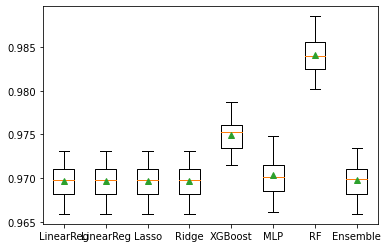

In [5]:
for name, model in models.items():
    scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=kf, n_jobs=-1)
    if(name == "LinearReg"): model.fit(X, y) 
    if(name == "Lasso"): model.fit(X, y) 
    results.append((-scores))
    names.append(name)
    print(name, ': %.6f (%.6f)' % (np.mean(-scores), np.std(-scores)), "Coef: " + " ".join(["%0.5f" % x for x in model.coef_]) if name == "LinearReg" or name == "Lasso" else "")

# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

### Generate final submission
Load training and test data.

In [ ]:
from utils.utils import load_data, get_input_matrix, load_submission_data, get_test_mask, generate_submission, get_preds_from_matrix

data = load_data('data/data_train.csv')
X_train, W_train = get_input_matrix(data)
X_test = load_submission_data('data/sampleSubmission.csv')
W_test = get_test_mask(X_test)

Train the individual models for the ensemble.

In [ ]:
from models.matrix_factorization import BFM
from models.similarity import SimilarityMethods

N_USERS = 10000
N_MOVIES = 1000

bfm_model = BFM(50, 0, N_MOVIES, 50, verbose=1, with_ord=True, with_iu=True, with_ii=True)
bfm_model.fit(data, None, None, iter=500)
bfm_preds = bfm_model.predict(X_test)
# Similarity predictions
sim_model = SimilarityMethods(0, N_USERS, N_MOVIES, similarity_measure="PCC", weighting='normal', method="item", k=30, signifiance_threshold=None)
sim_model.fit(X_train, None, W_train, log_rmse=False)
sim_preds_matrix = sim_model.predict(W_test, invert_norm=False)
sim_preds = get_preds_from_matrix(X_test, sim_preds_matrix)

Define the regression model and fit it with training data.

In [ ]:
regressor = LinearRegression()
regressor.fit(X, y)

Predict results for test data.

In [ ]:
y_test = np.stack((bfm_preds, sim_preds), axis=1)
regressor_preds = regressor.predict(y_test)

Save the final submissions.

In [ ]:
generate_submission(regressor_preds, 'data/sampleSubmission.csv')